In [ ]:
# Jesse Galef
# Using data scraped from C-SPAN's uncorrected closed caption transcripts


In [1]:
import pandas as pd
import numpy as np

In [23]:
import re

In [2]:
from bs4 import BeautifulSoup
import urllib

In [3]:
from scipy.sparse import csr_matrix, hstack
from scipy.stats import skew, kurtosis

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import StratifiedKFold

from sklearn.grid_search import GridSearchCV 

from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2, f_classif


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
# from spacy.en import English
# from spacy import attrs
# nlp_toolkit = English()
# This does word POS much much faster than nltk's pos_tagger

In [5]:
from nltk.tokenize import sent_tokenize, word_tokenize
# NLTK's sent_tokenize looks more accurate than Spacy's, and I only need to run it once
from nltk.corpus import stopwords
stops = list(stopwords.words('english'))

In [6]:
from textblob import TextBlob
# 

# POS dict

In [8]:
conjunctions = [u'and',u'that',u'but',u'or',u'as',u'if',u'when',u'than',u'because',
                u'while',u'where',u'after',u'so',u'though',u'since',u'until',u'whether',
                u'before',u'although',u'nor',u'like',u'once',u'unless',u'now',u'except']

In [9]:
pronouns = [u"all", u"another", u"any", u"anybody", u"anyone", u"anything", u"both", u"each", u"each other",
            u"either", u"everybody", u"everyone", u"everything", u"few", u"he", u"her", u"hers",
            u"herself", u"him", u"himself", u"his", u"i", u"it", u"its", u"itself", u"little",
            u"many", u"me", u"mine", u"more", u"most", u"much", u"my", u"myself", u"neither", 
            u"no one", u"nobody", u"none", u"nothing", u"one", u"one another", u"other", u"others",
            u"our", u"ours", u"ourselves", u"several", u"she", u"some", u"somebody", u"someone",
            u"something", u"that", u"their", u"theirs", u"them", u"themselves", u"these", u"they",
            u"this", u"those", u"us", u"we", u"what", u"whatever", u"which", u"whichever", u"who",
            u"whoever", u"whom", u"whomever", u"whose", u"you", u"your", u"yours", u"yourself", u"yourselves"]

# Transformer classes and Functions

In [10]:

def pipeline_features(step):
    # Passed a pipeline or pipeline step, recursively checks each named 
    # step and builds a list of features.
    # This returns the list in the same order that the estimator uses
    
    features = []
    if type(step)==Pipeline:
        for named_step in step.named_steps:
            features = features + pipeline_features(step.named_steps[named_step])
    elif type(step) == FeatureUnion:
        for transformer in step.transformer_list:
            features = features + pipeline_features(transformer[1])
    elif (type(step) == LogisticRegression):# or (type(step) == MultinomialNB):
        features = []
    else:
        features = step.get_feature_names()
    return features


In [11]:
def pipeline_coef_df(pipeline):
    # Passed a pipeline with estimator, creates a DataFrame of the coeficients for each class
    
    feature_list = pipeline_features(pipeline)
    if len(pipeline.named_steps['classifier'].classes_) == 2:
        coef_df = pd.DataFrame(pipeline.named_steps['classifier'].coef_, 
                           index = [pipeline.named_steps['classifier'].classes_[1]],
                           columns=feature_list).transpose()
        coef_df[pipeline.named_steps['classifier'].classes_[0]] = -coef_df[pipeline.named_steps['classifier'].classes_[1]]
    else:
        coef_df = pd.DataFrame(pipeline.named_steps['classifier'].coef_, 
                           index = pipeline.named_steps['classifier'].classes_, 
                           columns=feature_list).transpose()
    return np.e**(coef_df) # To get the odds ratios rather than the log odds
        
def top_coefs(pipeline, n_coefs):
    coef_df = pipeline_coef_df(pipeline)
    for candidate in coef_df.columns:
        print candidate,":"
        print coef_df.sort_values(by=candidate, ascending=False).ix[0:n_coefs,candidate]
        print

In [12]:
class best_vectorizer(TransformerMixin, BaseEstimator):
    # Transformer that takes a vectorizer and sklearn selector (like SelectKBest or SelectPercentile)
    # to find the n best features
    
    def __init__(self, vectorizer, selector, name):
        self.vectorizer=vectorizer
        self.selector=selector
        self.name = name
    
    def fit(self, X, y, **fit_params):
        vectors = self.vectorizer.fit_transform(X)
        self.selector.fit(vectors, y)
#         self.vectorizer.vocbulary = self.get_feature_names()
        return self

    def transform(self, X, **transform_params):
        return self.selector.transform(self.vectorizer.transform(X))
    
    def get_feature_names(self):
        return [self.name+feature for feature, used in zip(self.vectorizer.get_feature_names(), self.selector.get_support()) if used==True]
    
    

In [14]:
class used_multiple(TransformerMixin, BaseEstimator):
    def __init__ (self, vectorizer):
        self.vectorizer = vectorizer

    def fit(self, X, y=None, **fit_params):
        self.vectorizer.fit(X)
        return self

    def transform(self, X, **transform_params):
        vectors = pd.DataFrame(self.vectorizer.transform(X).todense(), columns=self.vectorizer.get_feature_names())
        vectors = vectors[vectors>1]
        vectors.fillna(0, inplace=True)
        return vectors

    def get_feature_names(self):
        return ['multiple_'+feat for feat in self.vectorizer.get_feature_names()]

In [15]:
class repeats(TransformerMixin, BaseEstimator):
    def __init__ (self):
        self.vectorizer = CountVectorizer()
    
    def fit(self, X, y=None, **fit_params):
        self.vectorizer.fit(X)
        return self
    
    def transform(self, X):
        repeats = []
        for sentence in X:            
            sent_repeats = []
            tokenized = self.vectorizer.build_tokenizer()(sentence)
            for i in range(len(tokenized)-1):
                if tokenized[i]==tokenized[i+1]:
                    sent_repeats.append(tokenized[i])
            repeats.append(' '.join(sent_repeats))
        return pd.DataFrame(self.vectorizer.transform(repeats).todense(), columns=self.get_feature_names())
    
    def get_feature_names(self):
        return ['repeated_'+feat for feat in self.vectorizer.get_feature_names()]

In [17]:
class quick_stats(TransformerMixin, BaseEstimator):
    # Incredibly rough/crude stats on each sentence in order to be fast - no parsing
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        stats = []
        for sentence in X:
            stats.append({
                    'length': len(sentence),
                    'spaces': sentence.count(' '),
                    'avg_word_ish': len(sentence)/float(sentence.count(' ')+1),
                    'clause_breaks': sentence.count(',') + sentence.count('-'),
                })
        return pd.DataFrame(stats)
    
    def get_feature_names(self):
        return ['length', 'spaces', 'avg_word_ish', 'clause_breaks']

In [18]:
class sentiments(TransformerMixin, BaseEstimator):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
    
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    
    def transform(self, X):
        sent_vectors = pd.DataFrame(self.vectorizer.transform(X).todense())
        polarities = []
        subjectivities = []
        for sentence in X:
            polarity, subjectivity = TextBlob(sentence).sentiment
            polarities.append(polarity)
            subjectivities.append(subjectivity)
        polarity_vectors = sent_vectors.copy().multiply(polarities, axis=0)
        subjectivity_vectors = sent_vectors.copy().multiply(subjectivities, axis=0)
        return polarity_vectors.join(subjectivity_vectors,lsuffix='polarity', rsuffix='subjectivity')
    
    def get_feature_names(self):
        return ['polarity_'+i for i in self.vectorizer.get_feature_names()]+['subjectivity_'+i for i in self.vectorizer.get_feature_names()]


# Start reading data

In [19]:
republicans = ['Trump']#,'Cruz','Kasich','Rubio','Bush']
democrats = ['Clinton']#,'Sanders']

long_df = pd.DataFrame()
for candidate in republicans+democrats:
    long_df = long_df.append(pd.read_csv(candidate+"_transcript_df.csv",index_col=0),ignore_index=True)

In [20]:
long_df.shape

(186, 6)

In [21]:
long_df.speaker.value_counts()

Trump      97
Clinton    89
Name: speaker, dtype: int64

In [25]:
%%time
sentence_list = []
for idx, speech in long_df.iterrows():
    raw = unicode(speech.text,errors='ignore').lower().replace('  ',' ').replace('>','').replace('w3','').replace(' v ','')
    #Fixing a few known glitches in the C-SPAN transcribing service
    sentences = sent_tokenize(raw)
    for sentence in sentences:
        sent_info = {}
        sent_info['sentence'] = sentence
        sent_info['speaker'] = speech.speaker
        sent_info['date'] = speech.date
        sent_info['title'] = speech.title
        sent_info['speech_idx'] = idx
        sent_info['tokens'] = len(re.findall('\\b\\w+\\b', sentence))
        sentence_list.append(sent_info)
raw_df = pd.DataFrame(sentence_list)

CPU times: user 9.15 s, sys: 730 ms, total: 9.88 s
Wall time: 10.2 s


In [26]:
raw_df.speaker.value_counts()

Trump      41131
Clinton    17649
Name: speaker, dtype: int64

(0, 100)

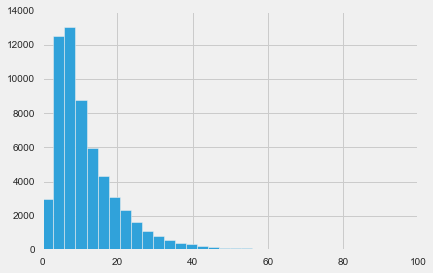

In [27]:
raw_df[raw_df.tokens <=200].tokens.hist(bins=50)
plt.xlim([0,100])

In [28]:
declarations = {}
declarations['Trump'] = '2015-06-16'
declarations['Clinton'] = '2015-04-11'


In [56]:
for i in range(20):
    print i, len(raw_df[raw_df.tokens>=i])/float(len(raw_df))

0 1.0
1 0.999574685267
2 0.982647158898
3 0.949880911875
4 0.897669275264
5 0.821725076557
6 0.737002381763
7 0.655512078938
8 0.580163320857
9 0.515226267438
10 0.45945899966
11 0.409544062606
12 0.366400136101
13 0.328291936033
14 0.295661789724
15 0.265209254849
16 0.237682885335
17 0.21318475672
18 0.191187478734
19 0.171554950663


In [57]:
min_length = 10
max_length = 150
df = raw_df[raw_df.tokens >= min_length]
df = df[df.tokens <= max_length]
# post_dec = [date > dec for date,dec in zip(df.date, [declarations[candidate] for candidate in df.speaker])]
# df = df[post_dec]

In [58]:
df.speaker.value_counts()

Trump      15699
Clinton    11305
Name: speaker, dtype: int64

In [59]:
max(df.speaker.value_counts())/float(len(df))

0.58135831728632792

# Data In, configure Pipeline

In [60]:
vectorizer = CountVectorizer(
#                          max_features = 7000,
                         ngram_range=(1,3), 
#                          stop_words='english',
                         decode_error='ignore',
                         min_df = 5,
                         binary=True,
                        token_pattern = '(?u)\\b\\w+\\b',
                            )

all_features = [
      ('top_words', best_vectorizer(vectorizer, selector=SelectKBest(chi2, 2000), name='')),
#       ('sentiment_terms', sentiments(CountVectorizer(max_features=2000))),
#     ('quickstats', quick_stats()),
#     ('consec', best_vectorizer(repeats(), selector=SelectKBest(chi2, 20), name='')),
#     ('multiple', used_multiple(CountVectorizer())),
    ]
    
    

In [81]:
pipeline = Pipeline([
  ('features', FeatureUnion(all_features)), # Currently the best_vectorizer
    ('classifier', LogisticRegression())]
)

# Cross Validate

In [62]:
which_candidates = ['Clinton','Trump']

In [63]:
from sklearn.cross_validation import cross_val_score
import time

In [83]:
t0=time.time()

condition = [speaker in which_candidates for speaker in df.speaker]
cand_df = df[condition]
kf = StratifiedKFold(y=cand_df.speaker, n_folds=5,random_state=42)
params = {'classifier__C': [.1,.3,1,3],
#           'features__top_words__selector__k': [1000,2000,4000,'all'],
          'features__top_words__vectorizer__binary': [True, False],
          'features__top_words__selector__score_func': [chi2, f_classif],              
         }

grid = GridSearchCV(estimator=pipeline, param_grid = params, scoring = 'roc_auc',cv=kf, verbose=2)

grid.fit(cand_df.sentence,[1 if speaker == 'Trump' else 0 for speaker in cand_df.speaker])
print time.time()-t0

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] features__top_words__vectorizer__binary=True, classifier__C=0.1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> 
[CV]  features__top_words__vectorizer__binary=True, classifier__C=0.1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> -   8.0s
[CV] features__top_words__vectorizer__binary=True, classifier__C=0.1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> 
[CV]  features__top_words__vectorizer__binary=True, classifier__C=0.1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> -   7.7s
[CV] features__top_words__vectorizer__binary=True, classifier__C=0.1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> 
[CV]  features__top_words__vectorizer__binary=True, classifier__C=0.1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> -  10.4s
[CV] features__top_words__vectorizer__binary=Tru

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  6.1min


[CV]  features__top_words__vectorizer__binary=True, classifier__C=1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> -   8.7s
[CV] features__top_words__vectorizer__binary=True, classifier__C=1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> 
[CV]  features__top_words__vectorizer__binary=True, classifier__C=1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> -  10.3s
[CV] features__top_words__vectorizer__binary=True, classifier__C=1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> 
[CV]  features__top_words__vectorizer__binary=True, classifier__C=1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> -   9.4s
[CV] features__top_words__vectorizer__binary=True, classifier__C=1, features__top_words__selector__score_func=<function chi2 at 0x11494ae60> 
[CV]  features__top_words__vectorizer__binary=True, classifier__C=1, features__top_words__selector__score_func=<function 

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 12.5min finished


763.271741152


In [85]:
scores = grid.grid_scores_
grid.best_params_

{'classifier__C': 1,
 'features__top_words__selector__score_func': <function sklearn.feature_selection.univariate_selection.f_classif>,
 'features__top_words__vectorizer__binary': True}

In [86]:
cv = []
scores = grid.grid_scores_
for combo in scores:
    pars = combo[0]
    pars['mean'] = combo[1]
    cv.append(pars)
pd.DataFrame(cv).sort_values(by='mean',ascending=False)

,classifier__C,features__top_words__selector__score_func,features__top_words__vectorizer__binary,mean
10,1.0,<function f_classif at 0x11494ad70>,True,0.896683
8,1.0,<function chi2 at 0x11494ae60>,True,0.896293
6,0.3,<function f_classif at 0x11494ad70>,True,0.895739
4,0.3,<function chi2 at 0x11494ae60>,True,0.895283
9,1.0,<function chi2 at 0x11494ae60>,False,0.894916
14,3.0,<function f_classif at 0x11494ad70>,True,0.894643
12,3.0,<function chi2 at 0x11494ae60>,True,0.894319
5,0.3,<function chi2 at 0x11494ae60>,False,0.894266
11,1.0,<function f_classif at 0x11494ad70>,False,0.893717
7,0.3,<function f_classif at 0x11494ad70>,False,0.893063


## Build a cross-val-predict-proba

In [87]:
pipeline=grid.best_estimator_

In [88]:
import time

cand_df = df[[speaker in which_candidates for speaker in df.speaker]]

n_folds = 50

segment_results = pd.DataFrame()
all_results = pd.DataFrame()
segment_coefs = [pd.DataFrame()]*n_folds

kf = StratifiedKFold(y=cand_df.speaker, n_folds =n_folds,random_state=42)

for i, (train_index, test_index) in enumerate(kf):
    t0 = time.time()
    pipeline.fit(cand_df.iloc[train_index].sentence, cand_df.iloc[train_index].speaker)
#     print 'done fitting',i,"time:",time.time()-t0
    segment_coefs[i] = pipeline_coef_df(pipeline)
    segment_results = pd.DataFrame(
                                    pipeline.predict_proba(cand_df.iloc[test_index].sentence),
                                    index=list(cand_df.iloc[test_index].index),
                                    columns=pipeline.named_steps['classifier'].classes_)
    print 'done predicting',i,"time:",time.time()-t0

    all_results=all_results.append(segment_results)
        
    

done predicting 0 time: 10.7160580158
done predicting 1 time: 10.0116939545
done predicting 2 time: 9.68340682983
done predicting 3 time: 9.71701693535
done predicting 4 time: 9.27776694298
done predicting 5 time: 9.24721813202
done predicting 6 time: 9.06327700615
done predicting 7 time: 9.5485560894
done predicting 8 time: 11.5674800873
done predicting 9 time: 12.1361260414
done predicting 10 time: 10.6690409184
done predicting 11 time: 9.67498111725
done predicting 12 time: 9.58068394661
done predicting 13 time: 9.30793404579
done predicting 14 time: 9.48682713509
done predicting 15 time: 9.74657797813
done predicting 16 time: 9.42199397087
done predicting 17 time: 10.7131040096
done predicting 18 time: 11.7162930965
done predicting 19 time: 10.4881601334
done predicting 20 time: 10.1552858353
done predicting 21 time: 9.58569097519
done predicting 22 time: 9.98932480812
done predicting 23 time: 9.42660617828
done predicting 24 time: 9.49927401543
done predicting 25 time: 9.562350034

In [89]:
cv_result = cand_df.copy().join(all_results)

In [90]:
cv_result.groupby('speaker').mean()

,speech_idx,tokens,Clinton,Trump
speaker,,,,
Clinton,141.634498,20.579655,0.721570,0.278430
Trump,48.424231,17.535257,0.198291,0.801709


In [91]:
cv_result['predict'] = cv_result.apply(lambda x: x[which_candidates].argmax(), axis = 1)

In [92]:
cv_result['correct'] = cv_result.predict == cv_result.speaker

In [93]:
cv_result.correct.value_counts()

True     22488
False     4516
Name: correct, dtype: int64

In [94]:
cv_result.correct.value_counts()[1]/float(len(cv_result.correct))

0.83276551621981931

0.910948823594


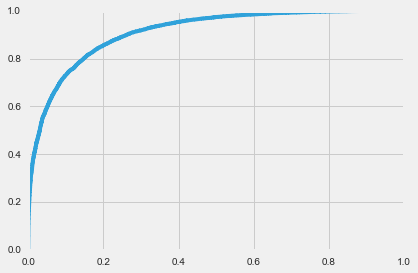

In [95]:
#  sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate
correct= [1 if speaker == 'Trump' else 0 for speaker in cv_result.speaker]
roc = roc_curve(correct, y_score=list(cv_result.Trump))
print roc_auc_score(correct, cv_result.Trump)
plt.plot(roc[0], roc[1])

In [686]:
sns.set_palette('deep')

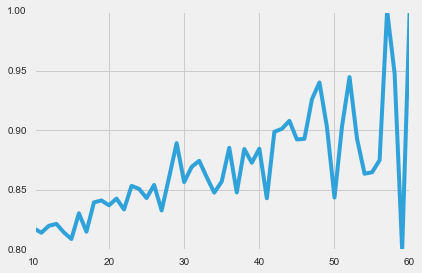

In [96]:
plt.plot(cv_result[(cv_result.tokens <=60)&(cv_result.tokens >=2)].groupby('tokens').mean()['correct'])

In [97]:
cv_result.head()

,date,sentence,speaker,speech_idx,title,tokens,Clinton,Trump,predict,correct
10,2016-09-03,i just wrote this the other day knowing that i...,Trump,1,Presidential Candidate Donald Trump Remarks in...,42,0.552823,0.447177,Clinton,False
11,2016-09-03,"for centuries, the african american church has...",Trump,1,Presidential Candidate Donald Trump Remarks in...,15,0.320470,0.679530,Trump,True
12,2016-09-03,it is from the pews and pulpits and christian ...,Trump,1,Presidential Candidate Donald Trump Remarks in...,58,0.998191,0.001809,Clinton,False
13,2016-09-03,and we are bound together and i see that today.,Trump,1,Presidential Candidate Donald Trump Remarks in...,10,0.543741,0.456259,Clinton,False
15,2016-09-03,the african-american fate immunity has been on...,Trump,1,Presidential Candidate Donald Trump Remarks in...,19,0.225275,0.774725,Trump,True


In [98]:

for candidate in which_candidates:
    print "Most",candidate,":"
    for idx, row in cv_result[cv_result.speaker == cv_result.predict].sort_values(by=candidate,ascending=False).iloc[0:10].iterrows():
        sent = row.sentence
        print "\t",sent[0].upper()+sent[1:]
        print "--",row.speech_idx, row.title
        print long_df.loc[row.speech_idx].link
        print "Predicted Clinton: ",row.Clinton
        print "Predicted Trump: ",row.Trump
        print
    print
    print
    

Most Clinton :
	I hope you will join me and that you will be part of this effort to build on the progress we have made under president obama to go further and to make it absolutely clear that we are fighting to break down barriers wherever they may be because we know america deserves nothing less and americans deserve to have the future that we will create together.
-- 138 Presidential Candidate Hillary Clinton Rally in Orangeburg, South Carolina
http://www.c-span.org/video/?405395-1/hillary-clinton-campaign-rally-orangeburg-south-carolina
Predicted Clinton:  0.999999999971
Predicted Trump:  2.85589102774e-11

	Think of what we are losing because we are not doing everything we can to reach out to those families and we know again from so much research year in the united states and around the world that mentoring and intervention will help those often stressed out young moms understand more about what they can do and to avoid the difficulties that stand in the way of their being able to 

In [99]:
cv_result.to_csv('cv_result_sept_8.csv')

In [107]:

for candidate in which_candidates:
    print "Most",candidate+"-like, but not:"
    for idx, row in cv_result[cv_result.speaker != cv_result.predict].sort_values(by=candidate,ascending=False).iloc[0:10].iterrows():
        sent = row.sentence
        print "\t",sent[0].upper()+sent[1:]
        print "--",row.speech_idx, row.title
        print long_df.loc[row.speech_idx].link
        print "Predicted Clinton: ",row.Clinton
        print "Predicted Trump: ",row.Trump
        print
    print
    print

Most Clinton-like, but not:
	This is why we have already  passed legislation to support  wounded warriors, veterans who  struggle with mental health challenges and earlier this week to support female veterans in  particular who need our help.
-- 22 Faith and Freedom Coalition Conference
http://www.c-span.org/video/?410912-1/faith-freedom-coalition-holds-annual-conference
Predicted Clinton:  0.999911271241
Predicted Trump:  8.87287592748e-05

	I say it is my high honor and distinct privilege for the sake of our troops who deserve a commander-in-chief who will have their back, for the sake of hard-working americans and businesses who deserve a president who will get washington, d.c. off their back, for the sake of a supreme court that will never turn its back on our god-given liberty or constitution, i give you the man who must be the next president of the united states of america, donald trump.
-- 9 Donald Trump Campaign Rally in Green Bay, Wisconsin
http://www.c-span.org/video/?413593-

In [100]:
sums = {}
for candidate in which_candidates:
    sums[candidate] = pd.DataFrame(index=segment_coefs[0].index)
t0 = time.time()
for i, segment in enumerate(segment_coefs):
    segment.drop_duplicates(inplace=True)
    for candidate in which_candidates:
        sums[candidate] = sums[candidate].join(segment[candidate], rsuffix=str(i))
        sums[candidate].drop_duplicates(inplace=True)


In [101]:
average_coef = pd.DataFrame()

for candidate in which_candidates:
    sums[candidate].fillna(1.0, inplace=True) # odds ratio
    #     average_coef[candidate] = sums[candidate].apply(lambda x: len(x) / sum([1./i for i in x]), axis=1)
    logged = np.log(sums[candidate])
    average_coef[candidate] = np.e**(logged.sum(axis=1) /  logged.shape[1])

In [102]:
print average_coef.sort_values(by='Trump', ascending=False).head(50)['Trump']
print
print average_coef.sort_values(by='Clinton', ascending=False).head(50)['Clinton']

tremendous       12.441219
islamic           9.954648
guy               9.253996
hispanics         7.962123
allowed           7.297891
conservative      7.191843
my wife           6.983890
poll              6.884786
frankly           6.683002
golf              6.527227
establishment     6.364172
badly             6.328923
politician        6.262710
highly            6.178180
japan             6.130588
incredible        6.078478
believe me        6.008609
ivanka            5.955501
deals             5.784829
almost            5.747028
guys              5.714904
an example        5.673463
indiana           5.633315
politicians       5.605007
stupid            5.573354
hillary           5.571508
rigged            5.533602
nice              5.440839
be very           5.336224
delegates         5.267174
common core       5.171817
by the way        5.154134
media             5.093614
television        4.919530
come in           4.894308
fox               4.856668
correct           4.851285
i

In [103]:
average_coef.to_csv('average_coef_sept_8.csv')

In [108]:

def color_map(percent, top, bottom):
    if percent >1:
        percent = 1
    diff = [t-b for t,b in zip(top, bottom)]
    
    return [(d*percent)+b for d,b in zip(diff, bottom)]
    

In [104]:
pronoun_coefs = average_coef.loc[[col for col in average_coef.index if col in pronouns]].sort_values('Trump', ascending=False)
# toplot = pronoun_coefs[((pronoun_coefs.Trump >= 1) | (pronoun_coefs.Clinton >=1))].copy()
toplot = pronoun_coefs.iloc[0:10].append(pronoun_coefs.iloc[-10:])


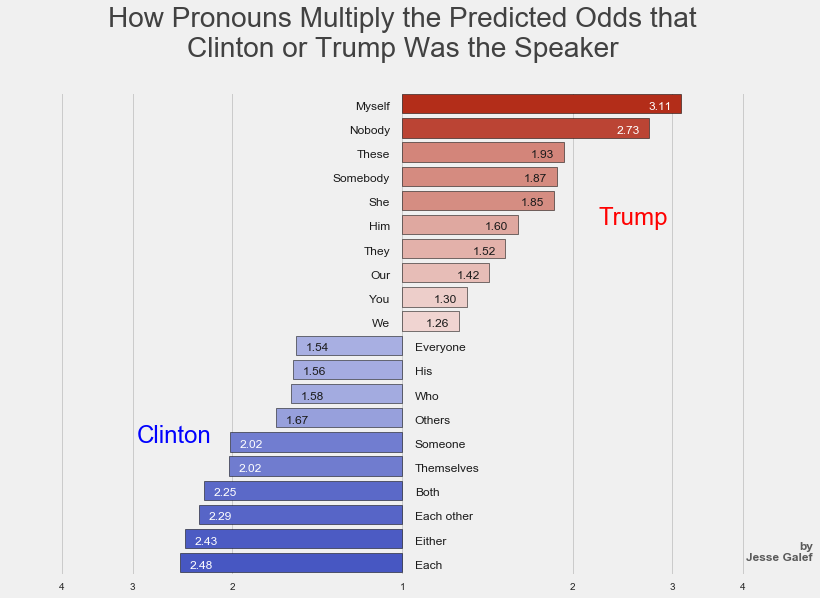

In [106]:

f, (ax1) = plt.subplots(1,1, figsize=(12,9))
label_size = 12
value_size = 9

vals = [np.log(x) for x in toplot.sort_values('Trump', ascending=False).Trump]

#minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]
colors = [color_map(-value/minimum, blue, white) if value < 0 else color_map(value/maximum, red, white) for value in vals]


sns.barplot(x=vals,
            y=toplot.sort_values('Trump', ascending=False).index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_title("How Pronouns Multiply the Predicted Odds that\nClinton or Trump Was the Speaker\n", fontsize=28, color=[.25,.25,.25])

# ax1.set_yticklabels([x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values], fontsize=16)


labels = [x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values]
for i, patch in enumerate(ax1.patches):
    width = patch.get_width()
    
    if patch.get_x() < 0:
        # Bars extending on the left
        label_x = .05
        label_halign = 'left'
        if patch.get_width() >= np.log(1.15):     
            value_x = patch.get_x()+.04
            value_halign = 'left'
        else:
            value_x = patch.get_x()-.04
            value_halign='right'
    else:
        # Bars extending on the right
        label_x = -.05
        label_halign = 'right'
        if patch.get_width() >= np.log(1.15):
            value_x = patch.get_width()-.04
            value_halign = 'right'
        else:
            value_x = patch.get_width() + .04
            value_halign = 'left'

    value_color = [.1,.1,.1]
    if patch.get_width()> np.log(2): value_color = 'white'
    ax1.text(label_x, patch.get_y()+.61, '%s'%(labels[i]), color=[.1,.1,.1], ha=label_halign, fontsize=label_size)   
    ax1.text(value_x, patch.get_y()+.61, '%1.2f'%(np.e**abs(vals[i])), color=value_color, ha=value_halign, fontsize=label_size)    

            
ax1.text(-np.log(2.95), 14, 'Clinton', color='b', fontsize=24)
ax1.text(np.log(2.95), 5, 'Trump', color='r', fontsize=24, ha='right')

ax1.set_yticklabels([])
ax1.set_xlabel('')
ax1.set_xlim([-np.log(5),np.log(5)])

ax1.set_xticks([-np.log(4),-np.log(3),-np.log(2),0,np.log(2),np.log(3), np.log(4)], minor=False)
ax1.set_xticklabels([4,3,2,1,2,3,4], minor=False)

f.text(.95, .07, 'by\nJesse Galef', color=[.2,.2,.2], fontsize=12, alpha=.8, ha='right', weight='bold', variant='small-caps')


plt.plot()
f.tight_layout(rect=[0,0,.95,.95])

In [771]:
print toplot.sort_values('Trump')['Clinton'][:15]
print toplot.sort_values('Clinton')['Trump'][:15]


each          2.478755
either        2.423942
each other    2.290494
both          2.244548
themselves    2.025851
someone       2.019864
others        1.672497
who           1.578782
his           1.547923
everyone      1.535259
we            0.791244
you           0.770145
our           0.702353
they          0.654019
him           0.625112
Name: Clinton, dtype: float64
myself      3.117861
nobody      2.721061
these       1.910636
somebody    1.877970
she         1.855257
him         1.599714
they        1.529007
our         1.423785
you         1.298457
we          1.263833
everyone    0.651356
his         0.646027
who         0.633400
others      0.597908
someone     0.495083
Name: Trump, dtype: float64


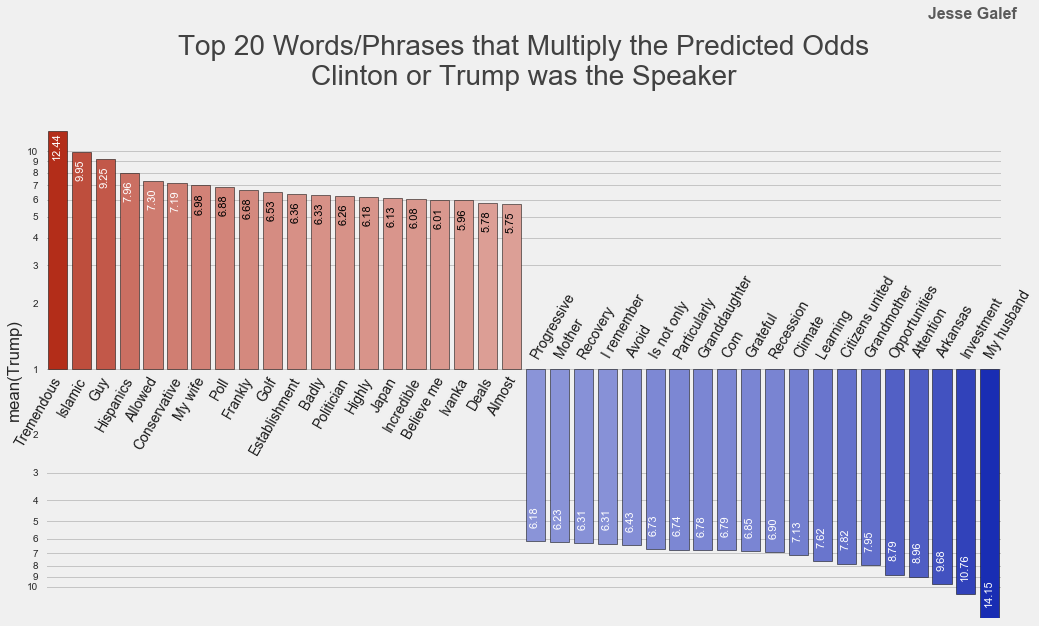

In [110]:
#  seaborn.barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, 
#  estimator=<function mean>, ci=95, n_boot=1000, units=None, orient=None, color=None,
#  palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, ax=None, **kwargs)¶
f, ax1 = plt.subplots(1,1, figsize=(15,9))

ax1.set_yticks([-1*np.log(x) for x in range(10,1,-1)]+[0]+[np.log(y) for y in range(2,11)])
    
ax1.set_yticklabels(range(10,1,-1)+['1']+range(2,11))


ax1.set_ylabel('')

label_font_size = 14
value_font_size=11
rotate =60
n_words = 20

color_adjustment = np.log(3)
val_series = average_coef.sort_values('Trump', ascending=False)['Trump']
vals = val_series[:n_words].append(val_series[-n_words:])
vals = np.log(vals)

# minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]

colors = [color_map(-(value+color_adjustment)/(minimum-color_adjustment), blue, white) if value < 0 else color_map((value-color_adjustment)/(maximum-color_adjustment), red, white) for value in vals]

sns.barplot(y=vals,
            x=vals.index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_title("Top "+str(n_words)+" Words/Phrases that Multiply the Predicted Odds\nClinton or Trump was the Speaker\n", fontsize=28, color=[.25,.25,.25])


labels = [x[0].upper()+x[1:] for x in vals.sort_values(ascending=False).index.values]

for i, patch in enumerate(ax1.patches):
    height = patch.get_height()
    if patch.get_y() < 0:
#         y = patch.get_y() -.5
        if height > np.log(6): 
            color = 'white'
        else:
            color = 'black'

        ax1.text(patch.get_x()+.1, .1, '%s'%(labels[i]), color=[.1,.1,.1], va='bottom', ha='left', rotation=rotate, fontsize=label_font_size)
        ax1.text(patch.get_x()+.15, patch.get_y()+.15, '%1.2f'%(np.e**abs(vals[i])), color=color, rotation=90, va='bottom', fontsize=value_font_size)
    else:
        if height > np.log(7): 
            color = 'white'
        else:
            color = 'black'
        ax1.text(patch.get_x()+.7, -.05, '%s'%(labels[i]), color=[.1,.1,.1], ha='right', va='top', rotation=rotate, fontsize=label_font_size)
        ax1.text(patch.get_x()+.15, patch.get_y()+height-.3, '%1.2f'%(np.e**abs(vals[i])), color=color, rotation = 90, va='bottom', fontsize=value_font_size)

            
f.text(.95, .95, 'Jesse Galef', color=[.2,.2,.2], fontsize=16, alpha=.8, ha='right', weight='bold', variant='small-caps')

ax1.set_ylim([-np.log(14), np.log(14)])

# ax1.yaxis.tick_right()
# ax1.yaxis.set_ticks_position('both')

for i, ygrid in enumerate(ax1.get_ygridlines()):
#     print ygrid.get_ydata(orig=False)[0], np.log(2)
#     if abs(ygrid.get_ydata(orig=True)[0]) == np.log(2):
    if i==8 or i==10:
        ygrid.set_xdata([0,0])

plt.grid(which='major', color=[.7,.7,.7], alpha=.7)
plt.margins(.3)
plt.plot()
f.tight_layout(rect=[0,0,.95,.95])



In [111]:
average_coef.to_csv('average_coef.csv', encoding='utf-8')